# Computational Physics - Exercise 4: Variational Monte Carlo methods

The major goal of this exercise consists of computing the expectation value of the Hamiltonian $ \hat{H} $ of a quantum system on a certain state $ \ket{\Psi_{T}(\{\alpha\})} $, where $ \{\alpha\} $ represents a set of variational parameters. It is customary to postulate  the state $ \ket{\Psi_{T}(\{\alpha\})} $ by means of an ansatz function $ \Psi_{T}(\{\alpha\},X) = \braket{X|\Psi_{T}(\{\alpha\})} $, with $ X $ being some generalized coordinates.
In particular, the expectation value of $ \hat{H} $ can be written in the following way:
$$
\braket{\Psi_{T}| \hat{H} | \Psi_{T}} \equiv E_{L}(\{\alpha\}) = \int dX P_{\{\alpha\}}(X) E_{L}(\{\alpha\},X), 
$$
with
$$
P_{\{\alpha\}}(X) = \frac{|\Psi_{T}(\{\alpha\},X)|^{2}}{\int dX |\Psi_{T}(\{\alpha\},X)|^{2}}
$$
representing a probability density and with the quantity
$$
E_{L}(\{\alpha\},X) = \frac{\hat{H}\Psi_{T}(\{\alpha\},X)}{\Psi_{T}(\{\alpha\},X)}
$$
generally called local energy. 
As a result, $ E_{L}(\{\alpha\}) $ can be evaluated with the aid of the so-called Metropolis-Hastings algorithm, which performs a Monte Carlo integration. This integral can therefore be seen as an average of the local energy weighted by the probability density $ P_{\{\alpha\}}(X) $
, from which the stochastic/random variables are sampled.

In [1]:
# Initialization
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sp
import math
from pylab import xlabel,ylabel
from numpy.random import uniform

# STEP 1 : VMC for a harmonic oscillator



## 1.1) Local energy for a test wavefunction for a 1D harmonic oscillator

In this first subsection, we consider the 1D harmonic oscillator Hamiltonian:
$$
\hat{H} = -\frac{1}{2}\frac{d^{2}}{dx^{2}} + \frac{1}{2}x^{2}
$$
and we want to obtain an analytical expression for the local energy $ E_{L}(\alpha,x) $ by using as trial wave function $ \Psi_{T}(\alpha,x) = e^{-\frac{x^{2}}{2\alpha^{2}}} $.
In order to do this, we exploit the generic definition of the local energy, namely:
$$
E_{L}(\alpha,x) = \frac{\hat{H}\Psi_{T}(\alpha,x)}{\Psi_{T}(\alpha,x)}.
$$
Therefore we have:
$$
\hat{H}\Psi_{T}(\alpha,x) = \left( -\frac{1}{2}\frac{d^{2}}{dx^{2}} + \frac{1}{2}x^{2} \right) e^{-\frac{x^{2}}{2\alpha^{2}}}.
$$
In particular, by acting with the first derivative we have:
$$
\frac{d}{dx} e^{-\frac{x^{2}}{2\alpha^{2}}} = -\frac{1}{\alpha^{2}} x e^{-\frac{x^{2}}{2\alpha^{2}}},
$$
so that we then obtain:
$$
-\frac{1}{\alpha^{2}} \frac{d}{dx} \left(x e^{-\frac{x^{2}}{2\alpha^{2}}}\right) = \frac{1}{\alpha^{2}}e^{-\frac{x^{2}}{2\alpha^{2}}} \left(\frac{x^{2}}{\alpha^{2}} - 1 \right).
$$
In this way we then have:
$$
\hat{H}\Psi_{T}(\alpha,x) = \frac{1}{2} e^{-\frac{x^{2}}{2\alpha^{2}}} \left[x^{2} + \frac{1}{\alpha^{2}} \left(1 - \frac{x^{2}}{\alpha^{2}} \right)\right].
$$
Finally the expression of the local energy is given by:
$$
E_{L}(\alpha,x) = \frac{\hat{H}\Psi_{T}(\alpha,x)}{\Psi_{T}(\alpha,x)} = \frac{1}{2} \left[x^{2} + \frac{1}{\alpha^{2}} \left(1 - \frac{x^{2}}{\alpha^{2}} \right)\right].
$$
In order to verify that for $ \alpha = 1 $ we get the expected result, we can compute the average value of $ E_{L}(\alpha,x) $, i.e. :
$$
\frac{\int_{-\infty}^{+\infty} dx |\Psi_{T}(\alpha,x)|^{2} E_{L}(\alpha,x)}{\int_{-\infty}^{+\infty} dx |\Psi_{T}(\alpha,x)|^{2}}.
$$
In the case of the denominator we have:
$$
\int_{-\infty}^{+\infty} dx |\Psi_{T}(\alpha,x)|^{2} = \int_{-\infty}^{+\infty} dx e^{-\frac{x^{2}}{2\alpha^{2}}} = \alpha \sqrt{\pi},
$$
while regarding the numerator we have:
$$
\int_{-\infty}^{+\infty} |\Psi_{T}(\alpha,x)|^{2} E_{L}(\alpha,x) = \left(\frac{1}{2} - \frac{1}{2\alpha^{4}} \right) \frac{\sqrt{\pi}}{2} \alpha^{3} + \frac{1}{2\alpha^{2}} \alpha \sqrt{\pi}.
$$
Consequently, by putting $ \alpha = 1 $ yields:
$$
\frac{\int_{-\infty}^{+\infty} dx |\Psi_{T}(\alpha = 1,x)|^{2} E_{L}(\alpha = 1 ,x)}{\int_{-\infty}^{+\infty} dx |\Psi_{T}(\alpha = 1,x)|^{2}} = \frac{\sqrt{\pi}}{2 \alpha \sqrt{\pi}} = \frac{1}{2},
$$
which is coherent with the standard ground state energy of the 1D harmonic oscillator.

## 1.2) Code for sampling points via the Metropolis algorithm

In the following cell we implement the Metropolis-Hastings algorithm in order to sample the squared modulus of the trial wave function, i.e. $ |\Psi_{T}(\alpha,x)|^{2} $, that appears in the expression of the expectation value of the local energy. More specifically according to this procedure: 
(1) we firstly take as initial point $ x_{0} = 0 $ indeed the trial wave function is a Gaussian centered at $ x = 0 $, so we start with the point associated with the highest probability; 
(2) We then propose a random move in terms of a new position $ x_{prop} = x_{0} + \Delta [rand(0,1) - 1/2] $, where $ rand(0,1) $ produces a uniform random number between $ [0,1) $, so that the new point $ x_{prop} $ is uniformily displaced from the previous value within a cube of side $ \Delta $. In other words, the Metropolis step $ \Delta (rand(0,1) - 1/2) $ represents a uniform random deviation from the initial coordinate between $ [-\Delta/2, \Delta/2] $;
(3) As next step we compute the so-called acceptance ratio and with our choice of the transition matrix we just need to evaluate the probability densities at $ x_{0} $ and at the subsequent point $ x_{prop} $, i.e.:
$$
p = \min \left(\frac{|\Psi_{T}(\alpha,x_{prop})|^{2}}{|\Psi_{T}(\alpha,x_{0})|^{2}},1 \right) = \min \left(\frac{e^{-\frac{x_{prop}^{2}}{\alpha^{2}}}}{e^{-\frac{x_{0}^{2}}{\alpha^{2}}}},1 \right);
$$
(4) In order to accept or reject the proposed move we then pick a uniform random number $ \xi $ between $ [0,1) $ and we compare it with $ p $. If $ p > \xi $ we accept the move, thus meaning that $ x_{prop} $ corresponds to the new element of the Markov chain. On the contrary, if $ p < \xi $ we reject the proposed move, so that we just keep the current value as the new element of the chain.
We choose $ \alpha = 0.8 $, since in this way we remain close to the ideal value $ \alpha = 1 $ of the standard 1D harmonic oscillator. 
We also follow a common criterion in order to choose the optimal value of $ \Delta $, that corresponds to the one that minimizes the autocorrelations among the samples and quite often this value is such that the acceptance ratio lies between $ 0.3 $ and $ 0.7 $. This works well for values of $ \Delta $ in the interval $ [0.4,0.6] $. In our case we set $ \Delta = 0.6 $.
Finally we repeat these 4 steps $ N = 10^{6} $ times,  which are the random variables/samples connected by means of the transition matrix at each step of the Markov chain. 

In [2]:
# Implementazione dell'algoritmo di Metropolis

x0 = 0
delta = 0.6
alpha = 0.8
N = 1000000
x1 = np.zeros(N)
psi_vec = np.zeros(N)
x1[0] = x0

for i in range(N-1):
    x = x1[i] + delta * (uniform(0,1)-0.5)
    psi0 = np.exp(-x1[i]**2/(alpha**2))
    psi = np.exp(-x**2/(alpha**2))
    ratio = psi/psi0
    if(ratio<1):
        p=ratio
    else: 
        p=1
    epsilon = 1e-8   
    max = 1-epsilon 
    xi = uniform(0,max)
    if(p>xi):
        x1[i+1] = x
    else:
        x1[i+1] = x1[i] 

## 1.3) Istogram of the sampled points

Now that we have sampled the points by means of the Metropolis algorithm, we can build an histogram to show their distribution. We decide the histogram to have 100 bins, equally distributed for positive and negative points. To observe the match with the square modulus of the wavefunction, we have to guarantee that both histogram and wavefunction share the same normalization. By the command "density = True" of the "histogram" function in the NumPy library, we set the histogram normalization to 1. Therefore, we have to impose the same for the wavefunction, whose norm is:

$$
\int_{-\infty}^{+\infty} dx |\psi_{T}(\alpha,x)|^{2} = \int_{-\infty}^{+\infty} dx \exp\left(-\dfrac{x^{2}}{\alpha^{2}}\right) = \alpha \sqrt{\pi}
$$

The normalized-to-one wavefunction and its square modulus are:

$$
\psi_{T}(\alpha,x) = \dfrac{1}{\sqrt{\alpha} \pi^{1/4}} \exp\left(-\dfrac{x^{2}}{2 \alpha^{2}}\right) \qquad \Longrightarrow \qquad 
|\psi_{T}(\alpha,x)|^{2} = \dfrac{1}{\alpha \sqrt{\pi}} \exp\left(-\dfrac{x^{2}}{\alpha^{2}}\right)
$$

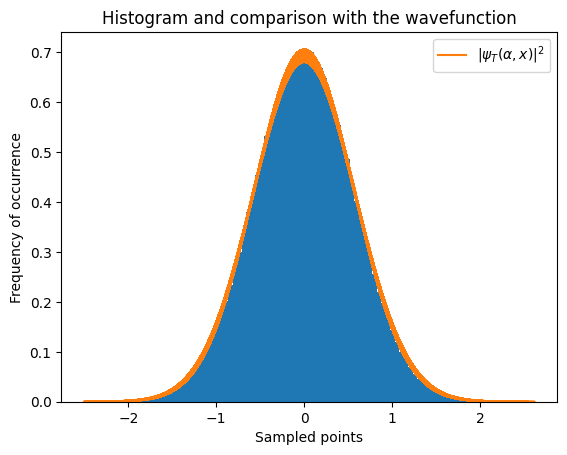

In [3]:
# Istogramma

n_bin = 100  # numero di bin nell'istogramma
psi_vec = (1/(np.sqrt(np.pi)*alpha))*np.exp(-x1**2/alpha**2)  # modulo quadro della funzione d'onda calcolato ai punti campionati
plt.hist(x1,n_bin,density=True)  # plotto l'istogramma dei punti campionati in 50 bin e normalizzato a 1
plt.plot(x1,psi_vec,label=r'$|\psi_{T}(\alpha,x)|^{2}$')  # plotto il modulo quadro della funzione d'onda
plt.legend()
plt.title('Histogram and comparison with the wavefunction')
plt.xlabel('Sampled points')
plt.ylabel('Frequency of occurrence')
hist, bin_edges = np.histogram(x1,n_bin,density = True)  # verifico altezza ed estremi dei bin

## 1.4) Average of the local energy

Here we want to compute the average of the local energy for a value of $\alpha$ close to the exact one: we choose $\alpha$ = 0.8. We evaluate it with a relative error of $10^{-2}$, $10^{-3}$ and $10^{-4}$. First, we choose different value for the number of steps, namely $N = 10^{4}, 10^{5}, 10^{6}, 10^{7}$, and for each one we sample points according to the Metropolis algorithm, where we set $\Delta = 0.6$.

In [ ]:
# Algoritmo di Metropolis per 4 valori del numero di step

x0 = 0
delta = 0.6
alpha = 0.8
N = np.array([10000, 100000, 1000000, 10000000])
x1 = np.zeros([N[3],4])
psi_vec = np.zeros([N[3],4])
for j in range(4):

    x1[0][j] = x0

    for i in range(N[j]-1):
        x = x1[i][j] + delta * (uniform(0,1)-0.5)
        psi0 = np.exp(-x1[i][j]**2/(alpha**2))
        psi = np.exp(-x**2/(alpha**2))
        ratio = psi/psi0
        if(ratio<1):
            p=ratio
        else: 
            p=1
        epsilon = 1e-8   
        max = 1-epsilon 
        xi = uniform(0,max)
        if(p>xi):
            x1[i+1][j] = x
        else:
            x1[i+1][j] = x1[i][j]
    print(j)

The aim is to verify that the relative error $\varepsilon_{r}$ goes like $\sqrt{N}$. Hence, for each N, we evaluate the local energy $E_{L}(\alpha,x)$ (at each point, with the expression provided above), its average $\langle H \rangle = E_{T}(\alpha)$ (where $T$ refers to the fact that we are considering a test wavefunction $\psi_{T}(\alpha,x)$), the average of the squared energy $\langle H^{2} \rangle$, the variance $\sigma^{2}$ and the relative error. In the following, we recall the corrisponding expressions.

$$
\langle H \rangle = E_{T}(\alpha) = \dfrac{1}{N} \sum_{i=1}^{N} E_{L}(\alpha,x_{i})
$$

$$
\langle H^{2} \rangle = \dfrac{1}{N} \sum_{i=1}^{N} E_{L}^{2}(\alpha,x_{i})
$$

$$
\sigma^{2} = \dfrac{ \langle H^{2} \rangle - \langle H \rangle ^{2}}{N-1}
$$

$$
\varepsilon_{r} = \dfrac{\sigma}{\langle H \rangle}
$$

In [5]:
# Calcolo di energia locale, energia media, varianza ed errore relativo

E_l = np.zeros([N[3],4])  # matrice per l'energia locale: 4 colonne contenenti i valori di energia locale ad ogni punto generato
E_sum = np.zeros(4)  # vettore di energia media per ogni valore di N
E2_sum = np.zeros(4)  # vettore di energia media al quadrato per ogni valore di N
sigma2 = np.zeros(4)  # vettore della varianza per ogni valore di N
rel_err = np.zeros(4)  # vettore dell'errore relativo per ogni valore di N

for j in range(4):  # riempiamo i vari vettori per ogni N
    E_l[:N[j],j] = 0.5*(x1[:N[j],j]**2*(1-(1/alpha**4))+(1/alpha**2))
    E_sum[j] = (1/N[j])*sum(E_l[:N[j],j])
    E2_sum[j] = (1/N[j])*sum((E_l[:N[j],j])**2)
    sigma2[j] = (E2_sum[j] - E_sum[j]**2)/(N[j]-1)
    rel_err[j] = np.sqrt(sigma2[j])/E_sum[j]

Now that we have the data, we want to be sure that the correct trend for the relative error $\varepsilon_{r}$ holds. Therefore, we plot $\varepsilon_{r}$ as a function of $N$ in a log-log scale plot, so that we are allowed to expect a straight-line behaviour. To confirm it, we perform a linear regression, to find the slope and the intercept of the straight line which better fits with our data. We can easily observe the expected trend in the following plot.

Text(0, 0.5, '$log_{10}(\\varepsilon_{r})$')

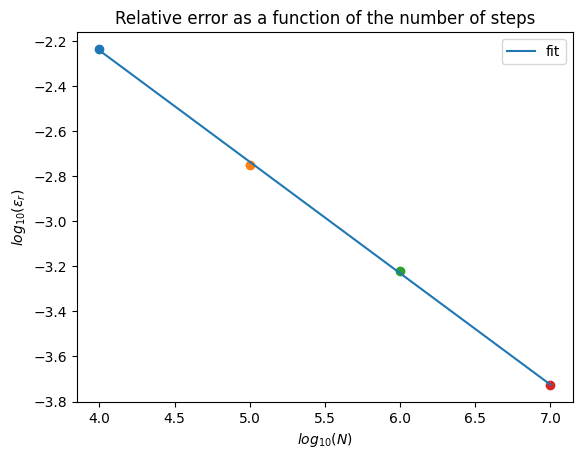

In [6]:
# Regressione lineare 

y = np.zeros(4)  # vettore dei logaritmi del numero di punti N
z= np.zeros(4)  # vettore degli errori relativi per ogni N
for j in range(4):  # riempio i vettori
    y[j] = math.log(N[j],10)
    z[j] = math.log(rel_err[j],10)

m,b = np.polyfit(y,z,1)  # fit per cercare coefficiente angolare e intercetta

plt.plot(y,m*y+b,label='fit')  # plot della retta con i parametri trovati
for j in range(4):  # plot degli errori relativi in funzione di N, in scala log-log
    plt.scatter(math.log(N[j],10),math.log(rel_err[j],10))
plt.legend()
plt.title('Relative error as a function of the number of steps')
plt.xlabel(r'$log_{10}(N)$')
plt.ylabel(r'$log_{10}(\varepsilon_{r})$')

We refer to the previous plot to find the number of sampled points which are needed to obtain the average energy with the required relative error. For instance, in order for $\varepsilon_{r} \sim 10^{-2}$, only $N < 10^{4}$ steps are necessary. In the following cell, we sample points, according to the Metropolis algorithm, starting from $N = 10$ and going on updating $N$ by summing 10 each time, until we reach the value of $N$ which yields to the desired relative error. Since we cannot be sure that there exist a value of $N$ associated to a relative errore which is exactly $10^{-2}$, we perform the Metropolis algorithm until $\varepsilon_{r}$ belongs to a small interval centered about $10^{-2}$, namely $\varepsilon_{r} \in [10^{-2} - \delta, 10^{-2} + \delta]$. Here we set $\delta = 10^{-4}$.

In [9]:
# Troviamo N2 e rel_err_2, ovvero il numero di step necessari per avere errore relativo dell'ordine di 10^{-2}

x0 = 0
delta = 0.6
alpha = 0.8
N = 10
rel_err = 0.5  # inizializzo l'errore relativo con un numero maggiore di zero

while(rel_err > 1e-2):  # vado avanti a campionare punti fintantoché l'errore relativo è maggiore di 10^{-2}
    x1 = np.zeros(N)
    psi_vec = np.zeros(N)
    x1[0] = x0

    for i in range(N-1):  # algoritmo di Metropolis
        x = x1[i] + delta * (uniform(0,1)-0.5)
        psi0 = np.exp(-x1[i]**2/(alpha**2))
        psi = np.exp(-x**2/(alpha**2))
        ratio = psi/psi0
        if(ratio<1):
            p=ratio
        else: 
            p=1
        epsilon = 1e-8   
        max = 1-epsilon 
        xi = uniform(0,max)
        if(p>xi):
            x1[i+1] = x
        else:
            x1[i+1] = x1[i]    
    
    E_l = 0.5*(x1**2*(1-(1/alpha**4))+(1/alpha**2))  # calcolo le varie quantità necessarie per l'errore relativo
    E_sum = (1/N)*sum(E_l)
    E2_sum = (1/N)*sum((E_l)**2)
    sigma2 = (E2_sum - E_sum**2)/(N-1)
    rel_err = np.sqrt(sigma2)/E_sum

    epsilon2 = 1e-4
    if(rel_err>1e-2-epsilon2 and rel_err<1e-2+epsilon2):  #trovo il valore di N e l'energia media con l'errore relativo desiderato
        rel_err2 = rel_err 
        N2 = N
        E_sum2 = E_sum
        break  # esco dal ciclo appena la condizione dell'if è soddisfatta la prima volta
    print(N)
    N = N + 10

print('To get a relative error of',rel_err2,'we need',N2,'steps. The average of the local energy is',E_sum2)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
To get a relative error of 0.009450655918611363 we need 140 steps. The average of the local energy is 0.7072223417773709


Then, we can repeat the same procedure to get a relative error $\varepsilon_{r} \in [10^{-3} - \delta, 10^{-3} + \delta]$, with $\delta = 2 \cdot 10^{-4}$. From the previous plot, we can see that such a relative error can be reached by a number of sampled points $N > 10^{5}$. Hence, we start with an initial value of $N$ equal to $10^{5}$ and we update it by adding each time 25000, in order not to wait too much time. 

In [11]:
# Troviamo N3 e rel_err_3, ovvero il numero di step necessari per avere errore relativo dell'ordine di 10^{-3}

x0 = 0
delta = 0.6
alpha = 0.8
N = 100000
rel_err = 0.5

while(rel_err > 1e-3):
    x1 = np.zeros(N)
    psi_vec = np.zeros(N)
    x1[0] = x0

    for i in range(N-1):
        x = x1[i] + delta * (uniform(0,1)-0.5)
        psi0 = np.exp(-x1[i]**2/(alpha**2))
        psi = np.exp(-x**2/(alpha**2))
        ratio = psi/psi0
        if(ratio<1):
            p=ratio
        else: 
            p=1
        epsilon = 1e-8   
        max = 1-epsilon 
        xi = uniform(0,max)
        if(p>xi):
            x1[i+1] = x
        else:
            x1[i+1] = x1[i]    

    E_l = 0.5*(x1**2*(1-(1/alpha**4))+(1/alpha**2))
    E_sum = (1/N)*sum(E_l)
    E2_sum = (1/N)*sum((E_l)**2)
    sigma2 = (E2_sum - E_sum**2)/(N-1)
    rel_err = np.sqrt(sigma2)/E_sum
    
    epsilon3 = 2*1e-4
    if(rel_err>1e-3-epsilon3 and rel_err<1e-3+epsilon3):
        rel_err3 = rel_err
        N3 = N
        E_sum3 = E_sum
    N = N + 25000
    print(N)

print('To get a relative error of',rel_err3,'we need',N3,'steps. The average of the local energy is',E_sum3)

125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
To get a relative error of 0.0009587180484464825 we need 350000 steps. The average of the local energy is 0.5583142898328903


The ratio between the number of steps needed in the two cases can be computed very easily.

In [39]:
# Rapporto del numero di steps

ratio32 = N3/N2

print('The ratio between the steps in the two cases is N3/N2 =',ratio32)

The ratio between the steps in the two cases is N3/N2 = 3888.8888888888887


As far as the last case is concerned, we do not perform a loop on $N$, because it takes too much time. Thus, since from the previous plot we see that $\varepsilon_{r} = 10^{-4}$ is reached for $N > 10^{7}$, we fix $N = 5 \cdot 10^{7}$ and look at the obtained relative error.

In [ ]:
# Troviamo N4 e rel_err_4

x0 = 0
delta = 0.6
alpha = 0.8
N = 50000000
rel_err = 0.5

while(rel_err > 1e-4):
    x1 = np.zeros(N)
    psi_vec = np.zeros(N)
    x1[0] = x0

    for i in range(N-1):
        x = x1[i] + delta * (uniform(0,1)-0.5)
        psi0 = np.exp(-x1[i]**2/(alpha**2))
        psi = np.exp(-x**2/(alpha**2))
        ratio = psi/psi0
        if(ratio<1):
            p=ratio
        else: 
            p=1
        epsilon = 1e-8   
        max = 1-epsilon 
        xi = uniform(0,max)
        if(p>xi):
            x1[i+1] = x
        else:
            x1[i+1] = x1[i]   

        print(i)

    E_l = 0.5*(x1**2*(1-(1/alpha**4))+(1/alpha**2))
    E_sum = (1/N)*sum(E_l)
    E2_sum = (1/N)*sum((E_l)**2)
    sigma2 = (E2_sum - E_sum**2)/(N-1)
    rel_err = np.sqrt(sigma2)/E_sum
    epsilon4 = 2*1e-5
    if(rel_err>1e-4-epsilon4 and rel_err<1e-4+epsilon4):
        rel_err4 = rel_err
        N4 = N
        E_sum4 = E_sum

    print(N)

print('To get a relative error of',rel_err4,'we need',N4,'steps. The average of the local energy is',E_sum4)

Also in this case, the ratio with the number of steps found in the previous cases can be obtained straightforwardly.

In [40]:
# Rapporto del numero di steps

N4 = 50000000

ratio42 = N4/N2
ratio43 = N4/N3

print('The ratio between the steps in the two cases is N4/N2 =',ratio42)
print('The ratio between the steps in the two cases is N4/N3 =',ratio43)

The ratio between the steps in the two cases is N4/N2 = 555555.5555555555
The ratio between the steps in the two cases is N4/N3 = 142.85714285714286


Finally, in the following table we summarize the results of the three cases.

| $\varepsilon_{r}$ | $N$ | $\langle H \rangle $ |
| --- | --- | --- |
|0.01  | 140 |0.707  |
| 0.001 | 350000 | 0.558 |
| 0.00008 |50000000  | 0.551 |

## 1.5) Local energy and running average

In this part of the exercise, we perform again the simulation up to the first $N_{step} = 5000$ steps and we plot the local energy and the running average. Firstly, we exploit again the metropolis algorithm to sample points used to evaluate the local energy.

In [ ]:
# Energia locale per i primi 5000 step

x0 =0
delta = 0.4
alpha = 0.8
Nstep = 5000
local_energy = np.zeros(Nstep+1)
x1 = np.zeros(Nstep+1)
E_l = np.zeros(Nstep+1)
x1[0] = x0
for i in range(Nstep):
    x = x1[i] + delta * (uniform(0,1)-0.5)
    psi0 = (-x1[i]**2/(alpha**2))
    psi = (-x**2/(alpha**2))
    ratio = np.exp(psi-psi0)
    if(ratio<1):
        p=ratio
    else: 
        p=1
    epsilon = 1e-8   
    max = 1-epsilon 
    xi = uniform(0,max)
    if(p>xi):
        x1[i+1] = x
    else:
        x1[i+1] = x1[i]    

    E_l[i] = 0.5*(((x1[i])**2)*(1-(1/alpha**4))+(1/alpha**2))
    print(i)

Then, we compute the running average, namely the vector of the average of the local energy at each step. Hence, at the generic step $n$, the runnign average is defined as:

$$
\langle H_{run} \rangle _{n} = \dfrac{1}{n} \sum_{i=1}^{n} E_{L}(\alpha,x_{n}) 
$$

From this definition, it naturally follows that the average energy is equal to the value of the running average at the last step. 

We can also estimate the lenght of the initial transient, namely the number of steps, from the beginning, up to which the runnign average has a randomly fluctuating behaviour, due to a very low amount of sampled points (little statistics). We evaluate it by finding the value of the step where the running average differs with the one evaluated 100 steps before less than 10^{-5}.

In [28]:
# Running average e ricerca del transiente

run_ave_1 = np.zeros(Nstep+1)
num = 0
for n in range(1,Nstep+1): 
    num += E_l[n]  # numeratore della running average ad ogni step
    run_ave_1[n] = num/n  # per trovare la running average basta quindi dividere per il numero corrispondente allo step corrente

for n in range(Nstep-100):
    if(abs(run_ave_1[n+100]-run_ave_1[n])<10**(-5)):
        n_star = n+100
        break
print('We have a transient up to the step number',n_star)    

We have a transient up to the step number 2260


Here we plot the local energy and the running average, including also the initial transient.

Text(0, 0.5, '$E_{L}, \\langle H_{run} \\rangle$')

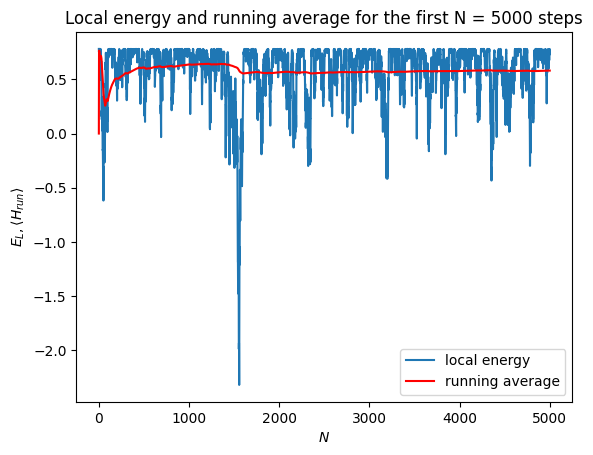

In [29]:
# Plot di energia locale e running average

number_of_steps = range(0,Nstep)
plt.plot(number_of_steps,E_l[0:Nstep],label='local energy')
plt.plot(number_of_steps,run_ave_1[0:Nstep],color = "r",label='running average')
plt.legend()
plt.title('Local energy and running average for the first N = 5000 steps')
plt.xlabel(r'$N$')
plt.ylabel(r'$E_{L}, \langle H_{run} \rangle$')

As mentioned before, we can easily evaluate the average energy by looking at the last value of the running average.

In [30]:
# Valor medio Hamiltoniana 

average_H = run_ave_1[Nstep]
print("The average energy for the first 5000 steps is",average_H)

The average energy for the first 5000 steps is 0.5811144387111702


Finally, we perform again the simulation starting from the value of the step after which we expect a less fluctuating behaviour of the local energy, namely after the transient. We expect a lower value of the average energy.

In [ ]:
# Energia locale dopo il transiente

Nstep = 5000
x1 = np.zeros(Nstep+1)
E_l_star = np.zeros(Nstep+1)
for i in range(n_star,Nstep):
    x = x1[i] + delta * (uniform(0,1)-0.5)
    psi0 = np.exp(-x1[i]**2/(alpha**2))
    psi = np.exp(-x**2/(alpha**2))
    ratio = psi/psi0
    if(ratio<1):
        p=ratio
    else: 
        p=1
    epsilon = 1e-8   
    max = 1-epsilon 
    xi = uniform(0,max)
    if(p>xi):
        x1[i+1] = x
    else:
        x1[i+1] = x1[i]    

    E_l_star[i] = 0.5*(x1[i]**2*(1-(1/alpha**4))+(1/alpha**2))
    print(i)

The average energy that we obtain after excluding the transient is 0.5342170620478693


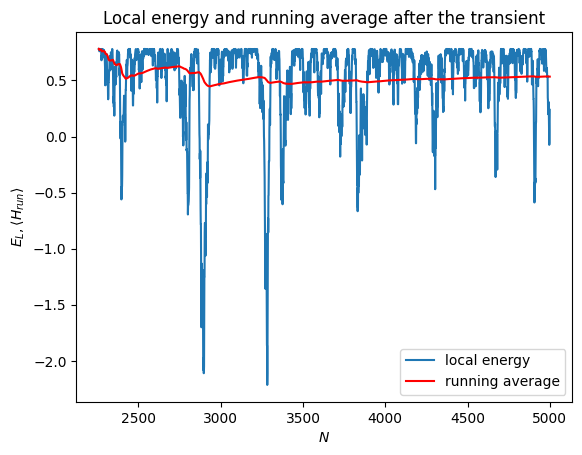

In [36]:
# Running average e nuovo plot

run_ave_11 = np.zeros(Nstep+1)
numm11 = 0
for n in range(n_star,Nstep):
    numm11 += E_l_star[n]
    run_ave_11[n] = numm11/(n-n_star+1)

number_of_steps = range(Nstep)
plt.plot(number_of_steps[n_star:Nstep],E_l_star[n_star:Nstep],label='local energy')
plt.plot(number_of_steps[n_star:Nstep],run_ave_11[n_star:Nstep],color = "r",label='running average')
plt.legend()
plt.title('Local energy and running average after the transient')
plt.xlabel(r'$N$')
plt.ylabel(r'$E_{L}, \langle H_{run} \rangle$')

average_H1 = run_ave_11[Nstep-1]
print("The average energy that we obtain after excluding the transient is",average_H1)

With the initial simulation, we get an average energy of about 0.581, while excluding the initial transient it becomes about 0.534. Therefore, it has decreased without considering the initial steps, as expected.